## Intel Classification Problem: 

The dataset contains images of natural scenes around the world.
This Data contains around 25k images of size 150x150 distributed under 6 categories.

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The objectif of this project is to build a convolutional neural networks to classify these images into their respective category.

We are first going to build a basic model, and then use transfer learning to improve performance.

## What are Convolutional Neural Networks?

A Convolutional Neural Network (CNN) is a type of deep neural network that is designed to process data with a grid-like topology, such as images or videos. It is inspired by the structure and function of the visual cortex in the brain, which is responsible for processing visual information.

CNNs consist of multiple layers of interconnected neurons that perform a series of mathematical operations on the input data. The core building blocks of a CNN are convolutional layers, pooling layers, and fully connected layers.

Convolutional layers apply a set of filters to the input data, each filter detecting a specific pattern or feature in the input. The filters slide over the input data, performing element-wise multiplication and summing up the results to produce a feature map. The pooling layers then downsample the feature map, reducing its size while retaining the most important features. Finally, the fully connected layers process the output of the convolutional and pooling layers, using it to make a prediction.

CNNs have proven to be very effective in image classification, object detection, and other computer vision tasks, and are widely used in various fields such as autonomous driving, medical image analysis, and natural language processing.

### Importing the required libraries:

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image 
import tensorflow as tf
import os 
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import np_utils

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

### Loading the images:

In [2]:
d = {}
X_train = []
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
for folder in os.listdir(train_path):
    image_folder =  train_path +"/"+ folder
    images = os.listdir(image_folder)
    d[folder] = len(images)
    for image in images:
        image_path = image_folder +"/"+ image
        x = Image.open(image_path)
        x = x.convert("RGB")
        x = np.array(x)
        img_resize = cv2.resize(x, (224,224))
        X_train.append(img_resize)


In [3]:
for key in d.keys(): 
    print("Found {} images for {}!" .format(d[key], key))

Found 2512 images for mountain!
Found 2382 images for street!
Found 2191 images for buildings!
Found 2274 images for sea!
Found 2271 images for forest!
Found 2404 images for glacier!


### Creating the train set:

In [4]:
X_train = np.array(X_train)
y_train = np.ones((14034,), dtype = "int32")

In [5]:
y_train[:2512] = 3 # for moutain
y_train[2512:4894] = 5 # for street 
y_train[4894:7085] = 0 # for buildings
y_train[7085:9359] = 4 # for sea
y_train[9359:11630] = 1 # for forest
y_train[11630:] = 2 # for glacier

In [6]:
X_train,y_train = shuffle(X_train,y_train, random_state = 42)

In [7]:
def get_label(id):
    label_dict = {0 : "buildings", 1: "forest", 2: 'glacier', 3:"mountain", 4 : "sea", 5 : "street"}
    return label_dict[id]

Text(0.5, 0, 'sea')

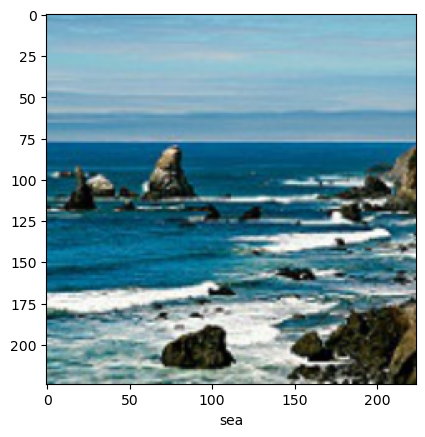

In [8]:
j = np.random.randint(0,10000)
plt.imshow(X_train[j])
plt.xlabel(get_label(y_train[j]))

In [9]:
y_train = np_utils.to_categorical(y_train, 6)

In [10]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size =0.1)

### What is data augmentation : 
Data augmentation is a technique used in machine learning and computer vision to artificially increase the size of a training dataset by creating new data from existing data. The process involves applying a set of transformations to the original data, such as rotation, scaling, flipping, cropping, adding noise, or changing the brightness and contrast.

The goal of data augmentation is to improve the performance of machine learning models by providing more training data to learn from, which can help prevent overfitting and improve generalization. By introducing variations in the training data, the model can learn to recognize the same object under different conditions, such as changes in lighting or viewpoint, and become more robust to these variations.

***Keras' ImageDataGenerator*** work as a python generator that allows us to generate new data on the fly, this allows you to train on an almost infinite stream of augmented image data without running out of memory.

In [11]:
aug = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=25, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2, 
        zoom_range=0.2,horizontal_flip=True, 
        fill_mode="nearest")

In [12]:
val_aug = ImageDataGenerator(
        preprocessing_function=preprocess_input)

In [13]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64,(3,3),padding = "same", strides = (2,2), activation = "relu", input_shape = (224,224,3)))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(128,(3,3), activation = "relu"))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(256,(3,3), activation = "relu"))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(512,(3,3), activation = "relu"))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(512,(3,3), activation = "relu"))
    model.add(MaxPool2D(2,2))
  
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation = "softmax"))
    return model

In [14]:
my_model = create_model()

In [15]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 256)      0

In [16]:
my_model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"])

### The problem with training with a large amount of images: 
Normally we would use X_train, y_train created previously to train our CNN, but since the amount of images is large a certain problem might arise which is:

Memory constraints: It could happen that your Kaggle notebook does not have enough memory to handle large datasets. When working with a large dataset, it's important to ensure that you have enough memory to load the data and perform the necessary computations. When working with a dataset with over 14000 training images, the ressources available might not be able to handle it during training.

To address these issues, we can try  using a generator to load the images in batches rather than loading the entire dataset into memory at once. 

For that, we can use the method 'flow_from_directory' of ImageDataGenerator that will generate batches of data for training or evaluation from a directory structure.

In [17]:
train_data = aug.flow_from_directory(
        '/kaggle/input/intel-image-classification/seg_train/seg_train',
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical')
val_data = val_aug.flow_from_directory('/kaggle/input/intel-image-classification/seg_test/seg_test',
        target_size=(224, 224),
        batch_size=128,
        shuffle = False,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Model training:

In [18]:
my_model_history = my_model.fit(train_data,
        epochs=50,
        validation_data=val_data)

Epoch 1/50
110/110 [==============================] - 204s 2s/step - loss: 1.8723 - accuracy: 0.3183 - val_loss: 1.2324 - val_accuracy: 0.4433
Epoch 2/50
110/110 [==============================] - 180s 2s/step - loss: 1.2942 - accuracy: 0.4479 - val_loss: 1.0479 - val_accuracy: 0.6023
Epoch 3/50
110/110 [==============================] - 180s 2s/step - loss: 1.1362 - accuracy: 0.5455 - val_loss: 0.9744 - val_accuracy: 0.6673
Epoch 4/50
110/110 [==============================] - 180s 2s/step - loss: 1.0414 - accuracy: 0.6065 - val_loss: 0.8241 - val_accuracy: 0.7043
Epoch 5/50
110/110 [==============================] - 182s 2s/step - loss: 0.9407 - accuracy: 0.6634 - val_loss: 0.8229 - val_accuracy: 0.7083
Epoch 6/50
110/110 [==============================] - 180s 2s/step - loss: 0.8806 - accuracy: 0.6930 - val_loss: 0.7001 - val_accuracy: 0.7510
Epoch 7/50
110/110 [==============================] - 180s 2s/step - loss: 0.8195 - accuracy: 0.7199 - val_loss: 0.7040 - val_accuracy: 0.7590

### Making predictions and visualizing errors::

In [19]:
predict = my_model.predict_generator(val_data,steps = 3000)
y_pred_classes = np.argmax(predict, axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

0.8396666666666667


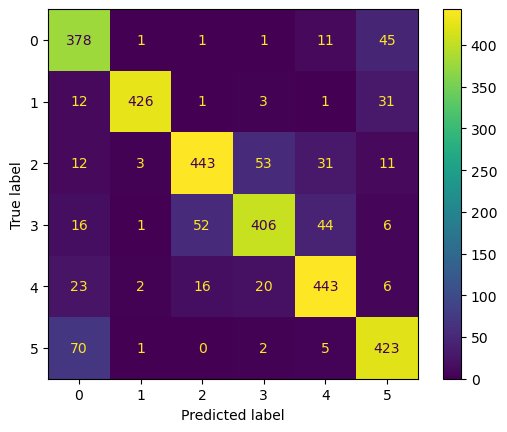

In [21]:
print(accuracy_score(val_data.classes,y_pred_classes))
ConfusionMatrixDisplay(confusion_matrix(val_data.classes,y_pred_classes)).plot()

In [22]:
X_test = []

test_path = "/kaggle/input/intel-image-classification/seg_test/seg_test"

for folder in sorted(os.listdir(test_path)):
    image_folder =  test_path +"/"+ folder
    images = sorted(os.listdir(image_folder))
    print ('Loaded the images of -'+'{} having {} images. \n'.format(folder, len(images)))
    for image in images:
        image_path = image_folder +"/"+ image
        x = Image.open(image_path)
        x = x.convert("RGB")
        x = np.array(x)
        img_resize = cv2.resize(x, (224,224))
        X_test.append(img_resize)


Loaded the images of -buildings having 437 images. 

Loaded the images of -forest having 474 images. 

Loaded the images of -glacier having 553 images. 

Loaded the images of -mountain having 525 images. 

Loaded the images of -sea having 510 images. 

Loaded the images of -street having 501 images. 



In [23]:
def plot_errors(true_label,predicted_label):
    rows,cols = 1,5
    fig, ax = plt.subplots(rows,cols,figsize=(10, 3))
    x = ((y_pred_classes == predicted_label) & (val_data.classes == true_label))
    y = np.where(x == True)[0]
    z = np.random.randint(0,len(y),5)
    fig.suptitle('Predicted : {}, Real : {}' .format(get_label(predicted_label), get_label(true_label)), fontsize=11)
    for col in range(cols):
        ax[col].imshow(X_test[y[z[col]]])
        ax[col].tick_params(
        axis = 'both',
        which='both',      
        bottom=False,
        left = False, 
        top=False,         
        labelbottom=False,
        labelleft=False)
    

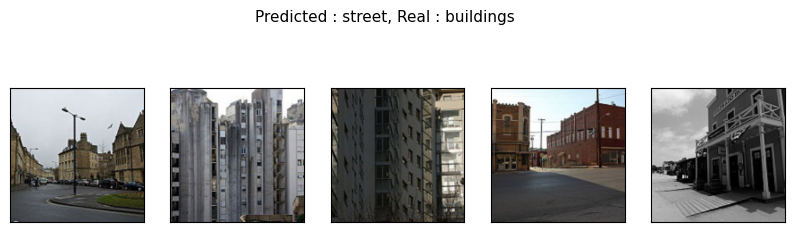

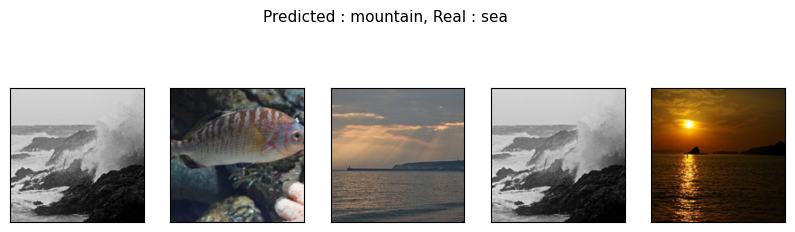

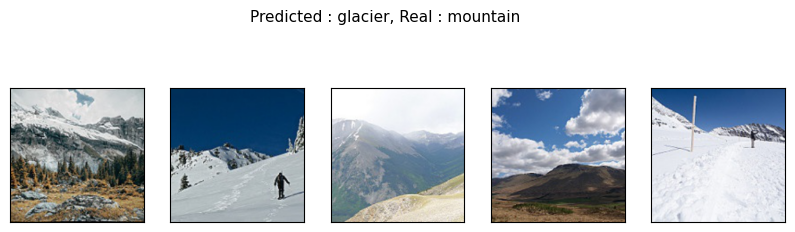

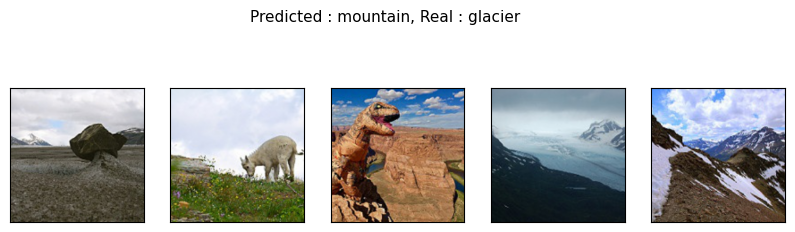

In [24]:
plot_errors(0,5)
plot_errors(4,3)
plot_errors(3,2)
plot_errors(2,3)

## What is transfer learning?

Transfer learning is a machine learning technique where a model trained on one task is re-purposed to solve a different but related task. Rather than starting the training process from scratch, the pre-trained model is used as a starting point and then fine-tuned or further trained on the new task.

Transfer learning is based on the idea that features learned from one task can be useful for solving other related tasks. For example, a model trained to recognize objects in images can be fine-tuned to recognize specific types of objects in new images. By using transfer learning, the model can learn to perform the new task faster and with less training data than if it were trained from scratch.

Transfer learning is widely used in computer vision. It can help to overcome the limitations of small datasets, reduce the amount of training time required, and improve the overall performance of the model.

Here we are going to use VGG16 which is a known architecture for image classification tasks, and it has achieved state-of-the-art performance on several benchmarks.

In [25]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [26]:
base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))

x = Flatten()(base_model(inputs))
y = Dense(128, activation = "relu")(x)
z = Dense(64, activation = "relu")(y)
outputs = Dense(6, activation='softmax')(z)
model = Model(inputs, outputs)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               3211392   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 17,934,726
Trainable params: 3,220,038
Non-trai

In [28]:
model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [29]:
history = model.fit(train_data,
        epochs=20,
        validation_data=val_data)

Epoch 1/20
110/110 [==============================] - 226s 2s/step - loss: 0.9850 - accuracy: 0.8290 - val_loss: 0.4423 - val_accuracy: 0.8780
Epoch 2/20
110/110 [==============================] - 207s 2s/step - loss: 0.3981 - accuracy: 0.8834 - val_loss: 0.3739 - val_accuracy: 0.8980
Epoch 3/20
110/110 [==============================] - 207s 2s/step - loss: 0.3266 - accuracy: 0.8964 - val_loss: 0.3430 - val_accuracy: 0.9003
Epoch 4/20
110/110 [==============================] - 202s 2s/step - loss: 0.2784 - accuracy: 0.9096 - val_loss: 0.2876 - val_accuracy: 0.9113
Epoch 5/20
110/110 [==============================] - 207s 2s/step - loss: 0.2441 - accuracy: 0.9149 - val_loss: 0.2867 - val_accuracy: 0.9137
Epoch 6/20
110/110 [==============================] - 208s 2s/step - loss: 0.2396 - accuracy: 0.9173 - val_loss: 0.3137 - val_accuracy: 0.9070
Epoch 7/20
110/110 [==============================] - 209s 2s/step - loss: 0.2099 - accuracy: 0.9252 - val_loss: 0.3248 - val_accuracy: 0.9147

### Visualizing Loss and accuracy curves:

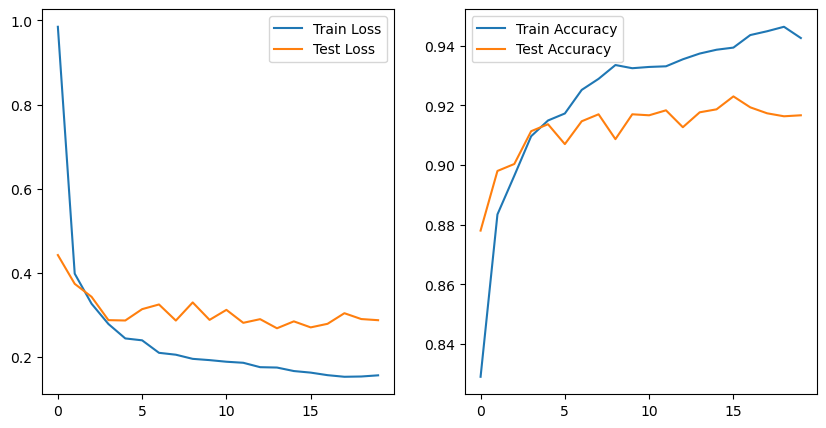

In [30]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].plot(history.epoch,history.history["loss"],label='Train Loss')
ax[0].plot(history.epoch, history.history["val_loss"],label='Test Loss')
ax[1].plot(history.epoch,history.history["accuracy"],label='Train Accuracy')
ax[1].plot(history.epoch, history.history["val_accuracy"],label='Test Accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

That's it for this project, some improvements could be to try out other architectures such as ResNet or Inceptions-V4 that have shown to perform particularly well on classification problems or we could potentially fine-tune more layers of the VGG16 architecture instead of just training the fully connected layers.

Training can be optimized by looking for the optimal hyperparameters such as the learning rate, as well as trying out other optimizers such as RMSProp. 

